In [1]:
# General use imports
import re
import nltk
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pre-processing imports
from wordcloud import WordCloud
from bs4 import BeautifulSoup as bs
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import text
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Model imports
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation

# Performance metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix

# Jupyter notebook settings
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML, Markdown, Image
plt.rcParams['figure.figsize'] = [24, 8]
sns.set_theme(style="darkgrid")

In [39]:
###########################################################################################################
# Data cleaning and EDA functions
###########################################################################################################
def article_demo(train):
    '''
    Display text from a specific article in xtrain.
    This function is called to demonstrate the effect of each data cleaning step.
    '''
    return train.loc[[305]]

def scrub_text(train):
    '''
    Clean article body text using BeautifulSoup and several regular expressions.
    '''
    # General regular expression lambda functions to remove parts of text
    remove_urls   = lambda x: re.sub(r'http\S+', '', x)
    remove_html   = lambda x: bs(x, "html").get_text()
    remove_chars  = lambda x: re.sub(r'[<>;\"\n\r\t\[\],.=_:{}()0-9$]', ' ', x)
    remove_space  = lambda x: re.sub(r' +', ' ', x).strip()
    to_lowercase  = lambda x: x.lower()
    remove_single = lambda x: re.sub(r"\b[a-z]{1,2}\b", "", x)

    # List cleaning functions in order reminiscent of a car wash
    cleaning_stages = [remove_urls, remove_html, remove_chars, to_lowercase, 
                       remove_space, to_lowercase, remove_single]

    # Apply cleaning functions to body text
    for stage in cleaning_stages:
        train['Text'] = train['Text'].apply(stage)
    return train

def remove_stop_words(train):
    '''
    Remove stop words from body text using sklearn collection of stop words.
    '''
    # Get stop word collection from sklearn and add some stop words common with reporting
    stop_words = text.ENGLISH_STOP_WORDS.union(["said", "say", "told", "people", "bbc", 
                                                "new", "old", "year"])

    # Define lambda function to remove stop words from a string
    remove_stop = lambda x: " ".join([word for word in str(x).split() if word not in stop_words])

    # Remove stop words from each article body text
    train['Text'] = train['Text'].apply(remove_stop)
    return train

def lemmatize(train):
    '''
    Lemmatize words in each article string using the nltk library.
    '''
    # Instantiate tokenizer to divide strings from whitespace and nltk lemmatizer
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    # Define lambda function to lemmatize string x
    lemmatize = lambda x: " ".join([lemmatizer.lemmatize(word) for word in tokenizer.tokenize(x)])

    # Lemmatize words from each article body text
    train['Text'] = train['Text'].apply(lemmatize)
    return train

###########################################################################################################
# Cluster permutation functions
###########################################################################################################
def assign_cluster_labels(cluster_predictions, assignments):
    '''
    Given a list of cluster assignment predictions, apply label assignments.
    '''
    for i, l in enumerate(assignments):
        cluster_predictions = [j if j != i else l for j in cluster_predictions]
    return cluster_predictions

def label_permute(yt, yp, labels, verbose=False):
    """
    Permute labels for yp given true labels yt.
    Return labeled yp with the highest accuracy score compared to yt.
    """    
    # Loop through each permutation and find the best accuracy score
    perm = set(itertools.permutations(labels))
    best_acc, best_assignments = -1, -1
    for p in perm:
        assignments, predictions = list(p), yp
        labeled_predictions = assign_cluster_labels(predictions, assignments)
        acc = np.round(accuracy_score(yt, labeled_predictions), 4)
        if acc > best_acc:
            best_acc, best_assignments = acc, assignments
    if verbose:
        print(f"\nlabel_order={best_assignments}, train_accuracy={best_acc}\n"+f"--"*50)
    return best_assignments, best_acc

###########################################################################################################
# Model fitting functions
###########################################################################################################
def fit_Kmeans(x_train, n_features, n_components):
    '''
    Fit and return a K-means clustering model.
    
    :param x_train:       The training data used to fit the model.
    :param n_features:    TF-IDF vectorizer hyperparameter.
    :param n_components:  SVD dimensionality reduction hyperparameter. 
    '''
    # Instantiate tfidf vectorizer and transform the training data
    vec_km = TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1,2), max_features=n_features)
    tfidf_tr_km = vec_km.fit_transform(x_train.Text)

    # Apply SVD dimensionality reduction and normalize article features
    lsa = TruncatedSVD(n_components=n_components)
    kmeans_pipeline = make_pipeline(lsa, Normalizer(norm='l1', copy=False))
    x_train_km = kmeans_pipeline.fit_transform(tfidf_tr_km)

    # Instantiate K-means clustering model and fit the training data
    kmeans = KMeans(n_clusters=5, algorithm="elkan").fit(x_train_km)

    # Predict article topics from the training set
    y_tr_km = kmeans.predict(x_train_km)

    # Permute cluster labels
    labels, acc = label_permute(yt=x_train.Category, yp=y_tr_km, labels=x_train.Category.unique())
    return kmeans, y_tr_km, vec_km, lsa, labels, acc

def fit_Hierarchical(x_train, linkage, affinity):
    '''
    Fit and return a hierarchical clustering model.
    
    :param x_train:    The training data used to fit the model.
    :param linkage:    Cluster merging hyperparameter.
    :param affinity:   Distance metric hyperparameter.
    '''
    # Instantiate tfidf vectorizer and transform the training data
    vec_agg = TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1,2), max_features=1000)
    tfidf_agg = vec_agg.fit_transform(x_train.Text)

    # Apply SVD dimensionality reduction and normalize article features
    lsa = TruncatedSVD(n_components=7)
    norm = Normalizer(norm='l1', copy=False)
    x_train_agg = norm.fit_transform(lsa.fit_transform(tfidf_agg))

    # Instantiate hierarchical clustering model and fit the training data
    hierarchical = AgglomerativeClustering(n_clusters=5, 
                                           linkage=linkage, 
                                           affinity=affinity, 
                                           compute_distances=True)
    
    # Predict article topics from the training set
    y_tr_agg = hierarchical.fit_predict(x_train_agg)

    # Permute cluster labels
    labels, acc = label_permute(yt=x_train.Category, yp=y_tr_agg, labels=x_train.Category.unique())
    return hierarchical, y_tr_agg, vec_agg, lsa, labels, acc

def fit_Dirichlet(x_train, miter, twp):
    '''
    Fit and return a latent dirichlet allocation model.
    
    :param x_train:    The training data used to fit the model.
    :param linkage:    Cluster merging hyperparameter.
    :param affinity:   Distance metric hyperparameter.
    '''
    # LDA can only use raw word counts, therefore we transform the training data with CountVectorizer
    vec_lda = CountVectorizer(analyzer='word', max_df=0.5, min_df=2, ngram_range=(1,2), max_features=1000)
    tfidf_lda = vec_lda.fit_transform(x_train.Text)

    # Instantiate LDA model and fit the training data
    lda = LatentDirichletAllocation(n_components=5, max_iter=miter, topic_word_prior=twp).fit(tfidf_lda)

    # Predict article topics from the training set by getting the maximum topic probability for each article
    y_tr_lda = lda.transform(tfidf_lda).argmax(axis=1)

    # Permute topic labels
    labels, acc = label_permute(yt=x_train.Category, yp=y_tr_lda, labels=x_train.Category.unique())
    return lda, y_tr_lda, vec_lda, labels, acc

<figure>
  <IMG SRC="https://www.colorado.edu/cs/profiles/express/themes/cuspirit/logo.png" WIDTH=50 ALIGN="right">
</figure>

## Predicting BBC news topics with unsupervised learning algorithms
*CSPB 4830 Machine Learning - Summer 2022*

* Author: Thomas Cochran

* Github: https://github.com/t-cochran/CSPB_4830_unsupervised_learning_project

__Project Description__

* The goal of this project is to analyze the body of text in BBC news articles and predict their topic, e.g. business, sports, or tech.

* This is a dataset we have worked with when covering non-negative matrix factorization (NMF), but I will be using it to train and evaluate other different unsupervised algorithms, namely: K-means clustering, hierarchical clustering, and latent dirichlet allocation (LDA).

__Problem Type__

* This is an unsupervised classification problem. We will be predicting an article topic using patterns and features in the article text. 

__Project Motivation__

* In addition to learning more about unsupervised algorithms, these methods can be useful for improving article organization and distribution online, either by suggesting topic tags to news articles or automatically applying them. More generally, topic modeling is useful for categorizing large bodies of unlabeled text data, which can organize the data to facilitate further analysis.

---

## Dataset Information

__Dataset source__

* The dataset is available from the following kaggle competition [[Link](https://www.kaggle.com/competitions/learn-ai-bbc/overview)]. 

__Dataset size and features__

* This dataset is tabulated. Rows correspond to articles, and columns correspond to the recorded features for each article.

* There are 3 features for each article in the training dataset. Below is a list of each feature with brief descriptions:

<style>
td {
  text-align: center;
  vertical-align: middle;
}
</style>
<table align="center">
  <tr> <th>Feature</th><th>Description</th><th>dtype</th></tr>
  <tr> <td>ArticleId</td><td>Unique identifier for an article.</td> <td>int</td></tr>
  <tr> <td>Text</td><td>The header and body text of the article.</td><td>str</td> </tr>
  <tr> <td>Category</td><td>Topic label for the article.</td> <td>str</td></tr>
</table>
<br>

* Here is a summary of the dataset's contents:

    * `train.csv` contains 1490 articles with topic category labels. 

    * 3.19 MB file size

__Why keep the topic category feature?__

* Note that all articles already have topic labels stored in the `Category` feature. Since this task will assign labels to questions using unsupervised learning algorithms (i.e. without using labels), why keep the topic labels? The answer is because, although I will not be training the unsupervised models using these labels, they are still useful for hyperparameter tuning and assessing training accuracy. 


__Loading the dataset__

In [40]:
# Load the dataset files and combine the training
train = pd.read_csv('dataset/train.csv')

# Select and display an article
print(article_demo(train).Text)

305    winter freeze keeps oil above $50 oil prices carried on rising on wednesday after cold weather on both sides of the north atlantic pushed us crude prices to four-month highs.  freezing temperatures and heavy snowfalls took crude oil prices past $50 a barrel on tuesday for the first time since november. declines in the dollar have also contributed to the rising oil price. us crude was trading at $51.39 at 0710 gmt in asian electronic trade on wednesday. a barrel of us crude oil closed up $2.80 at $51.15 in new york on tuesday. opec members said on tuesday that  given such high prices  the cartel saw no reason to cut its output.  although below last year s peak of $55.67 a barrel  which was reached in october  prices are now well above 2004 s average of $41.48. brent crude also rose in london trading  adding $1.89 to $48.62 at the close.  much of western europe and the north east of america has been shivering under unseasonably low temperatures in recent days. the decline in the u

---

## Data cleaning:

* When we worked with this dataset for our NMF assignment, we did very little to clean it. In this project, I will perform a variety of text cleaning processes that should allow our models to more readily extract context from the articles.

__Check rows for empty values__

In [4]:
# Print number of rows with empty values
print(f"Empty values in train set: {len(train[train.isna().any(axis=1)])}")

Empty values in train set: 0


__Clean the article text__

* The body text printed above already looks quite clean. There are no visible URLs, HTML tags, control characters, and all letters are lower case. However, there are still numbers and symbols which do not give much context. So, I will remove these using regular expressions.

* Additionally, just to make sure the printed article above is not a fluke, I will still scrub all article text using my own regular expressions which should remove URLs, HTML tags, control characters, single letters, and ensure all characters are lower case.

In [5]:
# Apply regular expression cleaning functions to the article body text
train = scrub_text(train)

# Display cleaned article body text
display(HTML(article_demo(train).to_html()))

,ArticleId,Text,Category
305,682,winter freeze keeps oil above oil prices carried rising wednesday after cold weather both sides the north atlantic pushed crude prices four-month highs freezing temperatures and heavy snowfalls took crude oil prices past barrel tuesday for the first time since november declines the dollar have also contributed the rising oil price crude was trading gmt asian electronic trade wednesday barrel crude oil closed new york tuesday opec members said tuesday that given such high prices the cartel saw reason cut its output although below last year peak barrel which was reached october prices are now well above average brent crude also rose london trading adding the close much western europe and the north east america has been shivering under unseasonably low temperatures recent days the decline the dollar five-week low against the euro has also served inflate prices the primary factor the weak dollar said victor shum singapore-based analyst with purvin and gertz expectations that rebound the dollar would halt the oil price rise were not immediately borne out wednesday morning oil prices carried upwards the dollar strengthened against the euro the pound and the yen several opec members said tuesday that cut production was unlikely citing rising prices and strong demand for oil from asia agree that not need cut supply the prices are much this fathi bin shatwan libya oil minister told reuters not think need cut unless the prices are falling below barrel added,business


__Removing stop words__

* Stop words are commonly used words in a given language that can be thought of as noise in the text data. They are words such as "on", "the", or "that". These words are essential for the structure of each sentence, but they do not offer much insight into the meaning of the sentence on their own. Therefore, I will remove stop words from each article. 

In [6]:
# Remove stop words from the article body text
train = remove_stop_words(train)

# Display cleaned article body text
display(HTML(article_demo(train).to_html()))

,ArticleId,Text,Category
305,682,winter freeze keeps oil oil prices carried rising wednesday cold weather sides north atlantic pushed crude prices four-month highs freezing temperatures heavy snowfalls took crude oil prices past barrel tuesday time november declines dollar contributed rising oil price crude trading gmt asian electronic trade wednesday barrel crude oil closed york tuesday opec members tuesday given high prices cartel saw reason cut output peak barrel reached october prices average brent crude rose london trading adding close western europe north east america shivering unseasonably low temperatures recent days decline dollar five-week low euro served inflate prices primary factor weak dollar victor shum singapore-based analyst purvin gertz expectations rebound dollar halt oil price rise immediately borne wednesday morning oil prices carried upwards dollar strengthened euro pound yen opec members tuesday cut production unlikely citing rising prices strong demand oil asia agree need cut supply prices fathi bin shatwan libya oil minister reuters think need cut unless prices falling barrel added,business


__Lemmatization__

* Lemmatization is a text mining technique that converts words to their root words, such as "prices" to "price" or "declines" to "decline". Reducing words to their root form can improve their weighting and grouping when vectorizing articles and training our models.

In [7]:
# Lemmatize words from the article body text
train = lemmatize(train)

# Display cleaned article body text
display(HTML(article_demo(train).to_html()))

,ArticleId,Text,Category
305,682,winter freeze keep oil oil price carried rising wednesday cold weather side north atlantic pushed crude price four-month high freezing temperature heavy snowfall took crude oil price past barrel tuesday time november decline dollar contributed rising oil price crude trading gmt asian electronic trade wednesday barrel crude oil closed york tuesday opec member tuesday given high price cartel saw reason cut output peak barrel reached october price average brent crude rose london trading adding close western europe north east america shivering unseasonably low temperature recent day decline dollar five-week low euro served inflate price primary factor weak dollar victor shum singapore-based analyst purvin gertz expectation rebound dollar halt oil price rise immediately borne wednesday morning oil price carried upwards dollar strengthened euro pound yen opec member tuesday cut production unlikely citing rising price strong demand oil asia agree need cut supply price fathi bin shatwan libya oil minister reuters think need cut unless price falling barrel added,business


---

## Exploratory Data Analysis (EDA):

__Distribution of topics__

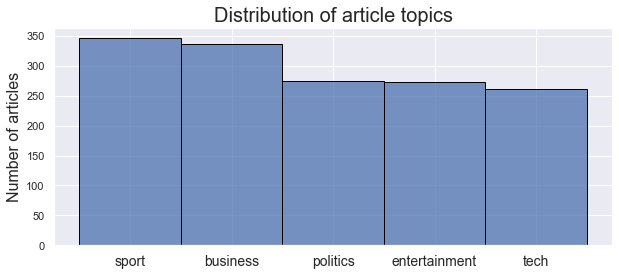

In [8]:
# Plot frequency of stack overflow questions by tag in descending order
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
sns.histplot(data=train.iloc[train.groupby('Category').Category.transform('size').argsort()[::-1]], 
             x="Category", ax=axes, edgecolor="black")
axes.set_title("Distribution of article topics", fontsize=20)
axes.set_ylabel("Number of articles", fontsize=16); axes.set_xlabel("", fontsize=16)
plt.xticks(fontsize=14);

* There is a slight bias toward sports and business topics. This indicates the models might be more accurate at predicting sports categories than than tech simply because there are more samples to derive sports or business specific features and patterns. 

__Distribution of word counts__

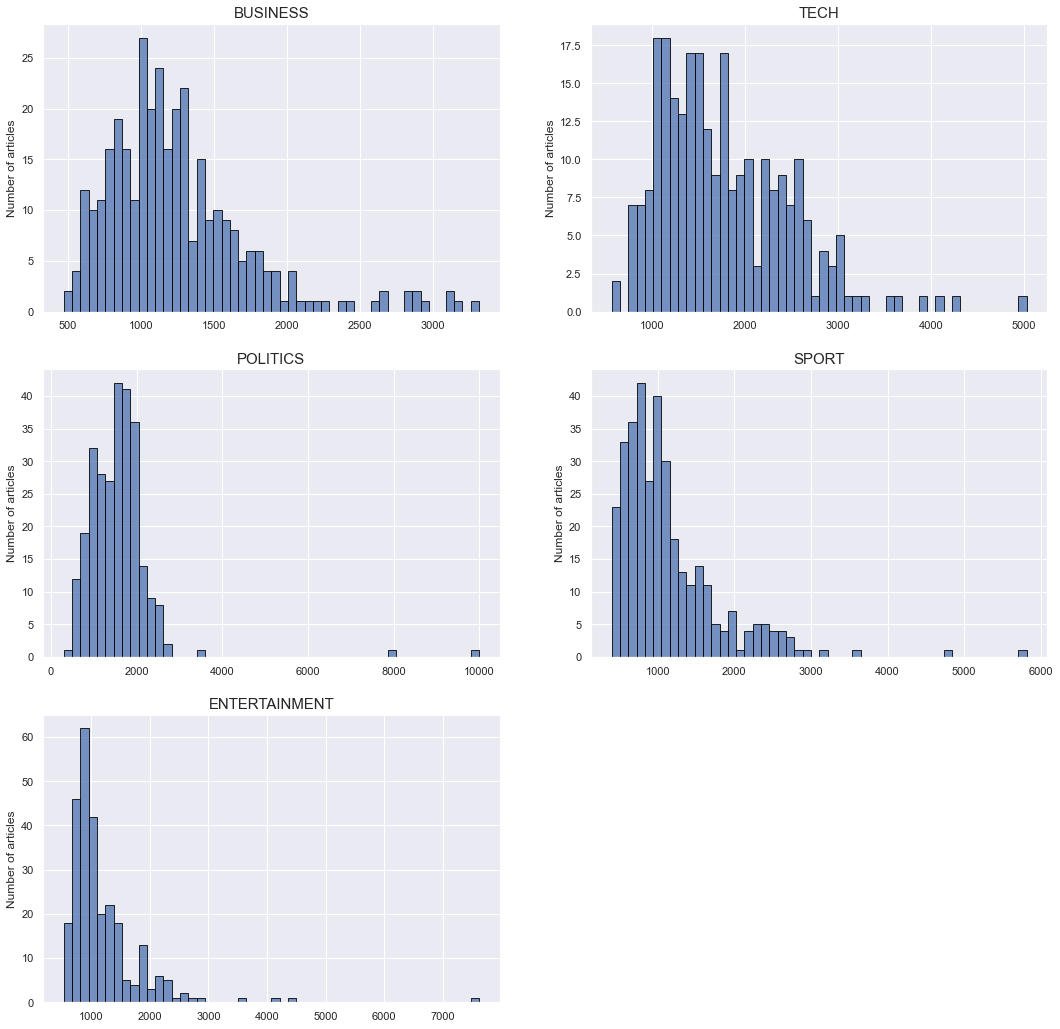

In [9]:
# Plot question word counts and label modes
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,18))
for category, ax in zip(train.Category.unique(), axes.flat):
    category_data = np.array([len(s) for s in train[train['Category'] == category]['Text']])
    sns.histplot(data=category_data, ax=ax, bins=50, edgecolor="black")
    ax.set_ylabel("Number of articles", fontsize=12);
    ax.set_title(f"{category.upper()}", fontsize=15)
axes[2,1].set_axis_off()

* Overall, most articles are limited to around 1000 to 1500 words. The politics, entertainment, and sports categories are the most succinct, while business and tech tend to be more verbose. 

* Verbose topics could be good, as there are more opportunities to use context specific words unique to the topic, such as frequently used buzz words. We will investigate this possibility next when we look at frequent n-grams.

__Frequent $n$-grams__

* $n$-grams are contiguous sequences of $n$ words taken from a text. If we look at the most frequently occurring $n$-grams, we can gain some insight into common types of phrases and contexts across different article topics which may help identify some differences between them.

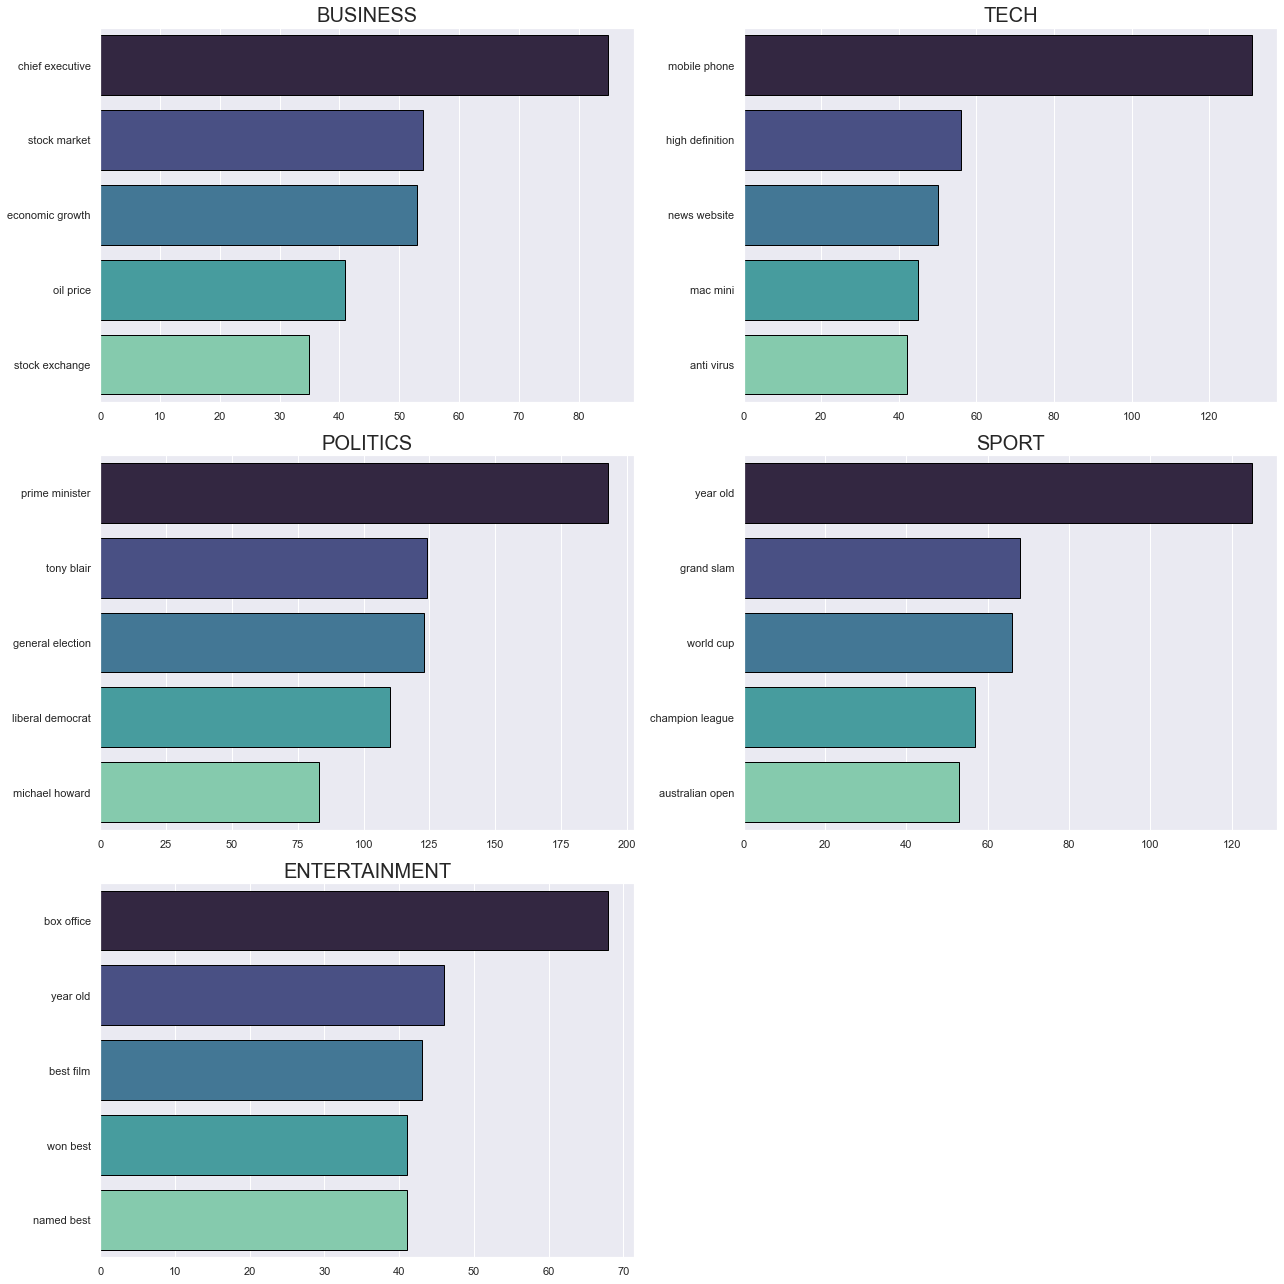

In [10]:
# Create a countvectorizer object to collect word counts for each question
countvec = CountVectorizer(ngram_range=(2,2), stop_words='english')

# Plot ngrams for the top 6 question tags
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,18))
for category, ax in zip(train.Category.unique(), axes.flat):
    word_counts = countvec.fit_transform(train[train['Category'] == category]['Text']).sum(axis=0)
    ngrams = [(w, word_counts[0, i]) for w, i in countvec.vocabulary_.items()]
    sorted_ngrams = sorted(ngrams, key=lambda x: x[1])[::-1]
    sns.barplot(x=[f[1] for f in sorted_ngrams[0:5]], y=[w[0] for w in sorted_ngrams[0:5]], 
                palette="mako", ax=ax, edgecolor="black")
    ax.set_title(f"{category.upper()}", fontsize=20)
axes[2,1].set_axis_off()
fig.tight_layout()

* The graphs above look at the most common bigrams (n=2 words per phrase), and we can see that each category has frequent word combinations that correspond to what we would intuitively expect, such as "box office" for entertainment or "prime minister" for politics. 

* This is promising because common bigrams appear to be distinct; that is, we do not see "analysts said" under sports, or "grand slam" under business, which could make applying labels using our clustering algorithms more difficult.

__Word clouds__

* Word clouds are visualizations of frequently used words, which are represented as larger words in the cloud. Below are word clouds corresponding to article topics in the dataset, and these let us visualize how distinct the article text is within each category.

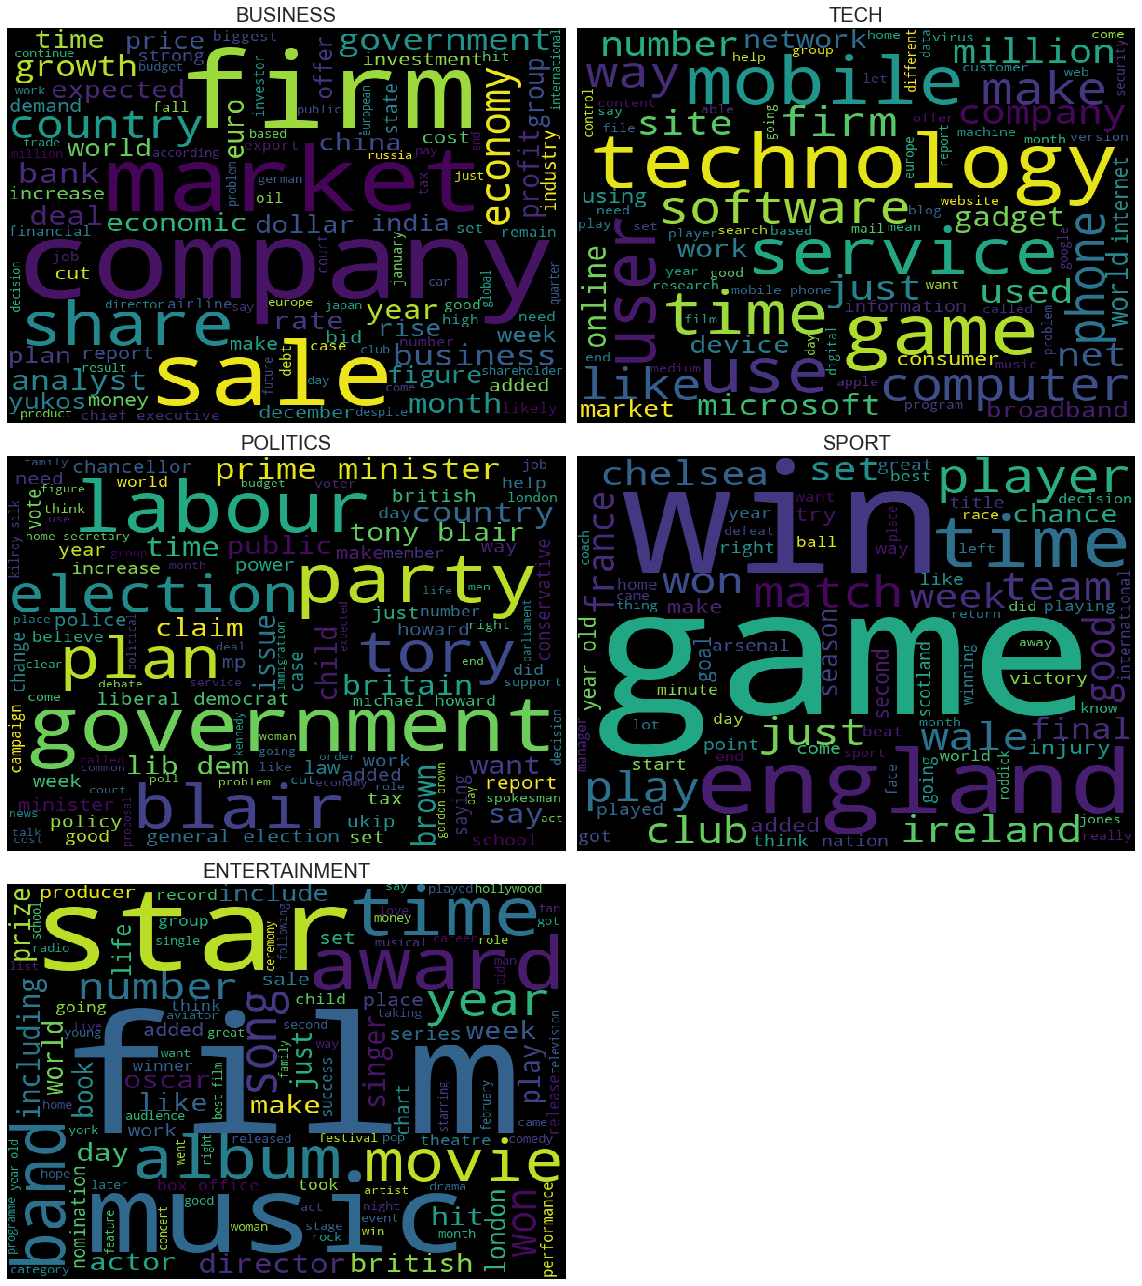

In [11]:
# Instantiate a wordcloud to be used for each sub plot
wordcloud = WordCloud(width=600, height=500, background_color='black', stopwords=text.ENGLISH_STOP_WORDS, min_font_size=12)

# Plot question wordclouds for each top nine question tag
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,18))
for category, ax in zip(train.Category.unique(), axes.flat):
    wordcloud.generate(' '.join(train[train['Category'] == category]['Text']))
    im = ax.imshow(wordcloud, interpolation='nearest', aspect='auto')
    ax.axis('off'); ax.set_title(f"{category.upper()}", fontsize=20)
axes[2,1].set_axis_off()
plt.tight_layout(pad=1)

* As with $n$-grams, each category appears to have unique and intuitive profiles such as "market" and "economy" for business, or "government" and "party" for politics. This is promising because it may facilitate separation between topics from our clustering algorithms.

__EDA summary__

* Article category counts are slightly skewed towards `sports` and `business`, however other categories have a similar number of articles.

* All categories have a comparable number of words per article, with the most common range being around 1000 to 1500 words. The topics `Tech` and `Business` have a wider distribution of words per article than other article topics. 

* There are several distinct bigrams within each category that make intuitive sense, such as "grand slam" for sports or "mac mini" for tech.

* Wordclouds also show distinct profiles for common words in each category. Vectorizing both common words and bigrams may be more effective when training our algorithms than one or the other.

## Model Selection:

__Model 1: K-Means clustering__

* K-means is suited for this task because it allows us to group articles into topic clusters which can then be labeled. In our case, we will be vectorizing articles into words and then applying weights to each word depending on their importance to the article using term frequency-inverse document frequency (TF-IDF). Using these weights, articles will be clustered around similar average TF-IDF weightings.

__Model 2: Hierarchical clustering__

* Hierarchical clustering is suited for this task because, like K-means, it also allows us to group similar articles into distinct clusters which can then be labeled with topics. Unlike K-means, in hierarchical clustering we will be iteratively grouping similar subsets of articles.

__Model 3: Latent Dirichlet allocation (LDA)__

* We have not covered this algorithm in class, however it seems well suited for this task since we are focusing on topic modeling or text mining. LDA is a bayesian model that works by assigning the words in each article a set probability to be of several topics, i.e. $P(\text{articleWord}$ | $\text{topic})$. Initially, these are assigned randomly. As more articles are processed, the probabilities are iteratively updated which eventually gives us an idea of how likely each article is a member of the discovered topics. See the [source article](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf) for further information. 

## Model Training:

__TF-IDF vectorization__

* I will be using term frequency-inverse document frequency (TF-IDF) to vectorize and extract the most relevant words from each article prior to training each model. This is done by assigning higher weights to words that occur frequently within articles, but infrequently across all articles.

__Balancing training data__

* Through EDA, we have found there is a slight skew in the training data towards `sports` and `business` categories. I will opt to balance the training data by randomly undersampling categories with more articles. I will do this until all categories have an equivalent number of articles. 

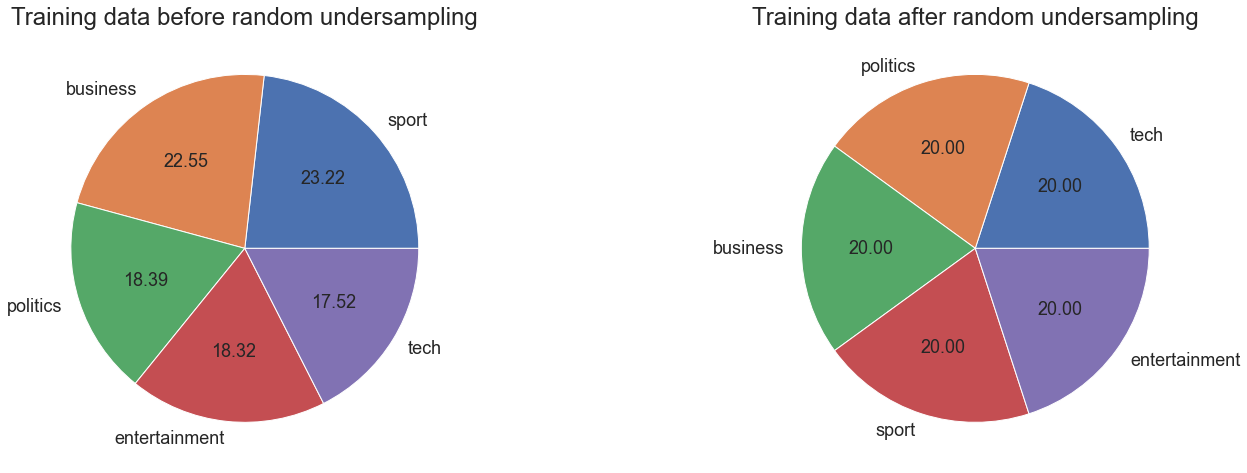

In [12]:
# We will balance by undersampling to the size of the smallest category 
smallest_category = len(train[train['Category'] == 'tech'])
train_ = train.groupby('Category').apply(lambda s: s.sample(smallest_category))[['Text']].reset_index()

# Shuffle the data after under sampling
train_ = train_.sample(frac=1)

# Plot the results
fig, ax = plt.subplots(ncols=2)
for training_set, time, ax in zip([train, train_], ["before", "after"], ax):
    training_set.Category.value_counts().plot.pie(autopct="%.2f", ax=ax, textprops={'fontsize': 18})
    ax.set_title(f"Training data {time} random undersampling", fontdict={'fontsize':24})
    ax.set_ylabel('')

__Model 1: K-Means clustering__

* In K-means, it's common to tune `n_clusters` using the "elbow plot". If a dataset has no labels, then we would need to create this plot in order to gauge the number of clusters to set. However, I will omit this step since the dataset is balanced around 5 topic categories, therefore we expect `n_clusters=5` to be the optimal clusters for classifying topics. 

* The TF-IDF hyperparameter `max_features` will be tuned instead, which controls the maximum number of features (i.e. words columns) in the TF-IDF feature matrix. This is important for K-means because lower `max_features` makes the input matrix more sparse, so we can expect lower performance at lower values of `max_features`.

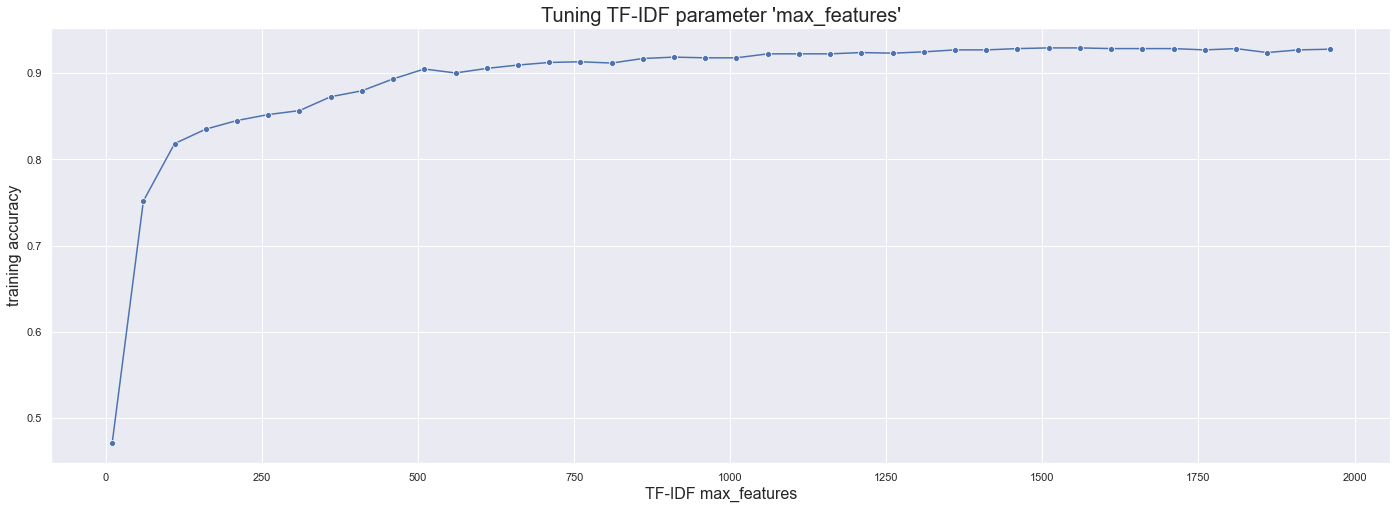

In [13]:
# Tune max_features parameter of tf-idf vectorizer
acc_scores = []
for i in range(10, 2000, 50):
    _, _, _, _, _, acc = fit_Kmeans(train_, n_features=i, n_components=5)
    acc_scores.append(acc)

# Plot results
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.lineplot(x=[i for i in range(10, 2000, 50)], y=acc_scores, marker='o', ax=ax)
ax.set_ylabel("training accuracy", fontsize=16)
ax.set_xlabel("TF-IDF max_features", fontsize=16);
ax.set_title("Tuning TF-IDF parameter 'max_features'", fontsize=20);

* I have also transformed the data using a dimensionality reduction algorithm called latent semantic analysis (LSA; see [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)) because K-means tends to perform poorly at higher dimensions. Next, I will tune the `n_components` for LSA, which sets the desired dimensionality:

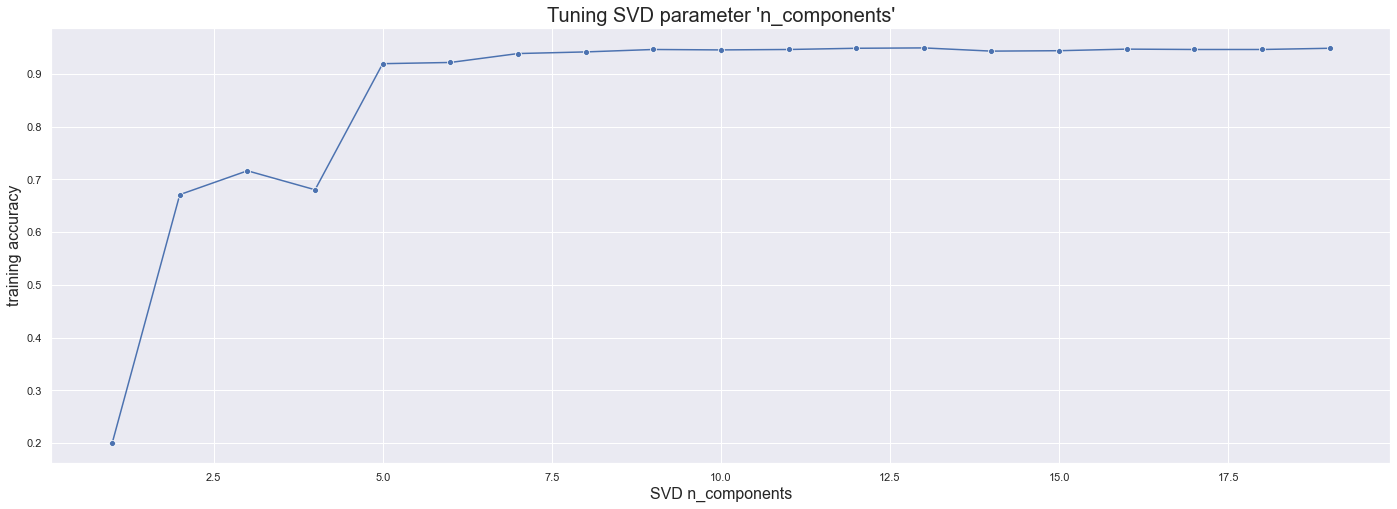

In [14]:
# Tune n_components of LSA
scores = []
for i in range(1, 20, 1):
    _, _, _, _, _, acc = fit_Kmeans(train_, n_features=1000, n_components=i)
    scores.append(acc)

# Plot results
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.lineplot(x=[x for x in range(1, 20, 1)], y=[x for x in scores], marker='o', ax=ax)
ax.set_ylabel("training accuracy", fontsize=16)
ax.set_xlabel("SVD n_components", fontsize=16);
ax.set_title("Tuning SVD parameter 'n_components'", fontsize=20);

* At `n_components` > 7 we reach a point of diminishing returns where accuracy does not increase despite larger explained variance.

In [16]:
# Fit the final k-means clustering model 
model_km, x_train_km, vec_km, lsa_km, km_labels, km_acc = fit_Kmeans(train_, n_features=1000, n_components=7)

__Model 2: Agglomerative clustering__

* For agglomerative clustering, I will be focusing on finding an optimal `linkage` parameter, which determines how subsets of clusters are merged. I will also find an optimal `affinity` parameter, which is the linkage metric.

In [17]:
# Permute linkage and affinity parameters
linkage_methods = ['complete', 'average', 'single']
distance_metrics = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
perm = list(itertools.product(linkage_methods, distance_metrics))

# The 'ward' linkage method can only be used with 'euclidean' distance
perm.append(('ward', 'euclidean'))

# Check linkage and distance metrics to find the best one
display(Markdown("### Linkage and affinity parameter permutations"))
best_acc, best_model, best_p = (-1, -1), -1, -1
for p in perm:
    print(p)
    model, _, _, _, labelorder, acc = fit_Hierarchical(train_, linkage=p[0], affinity=p[1])
    if acc > best_acc[1]:
        best_acc = (labelorder, acc)
        best_model = model
        best_p = p

# Print linkage method and distance method for best result
display(Markdown("### Optimal linkage and affinity parameters"))
print(f"best linkage method: {best_p[0]}\nbest distance metric: {best_p[1]}")
print(f"labelorder: {best_acc[0]}\ntraining accuracy={best_acc[1]}")


### Linkage and affinity parameter permutations

('complete', 'euclidean')
('complete', 'l1')
('complete', 'l2')
('complete', 'manhattan')
('complete', 'cosine')
('average', 'euclidean')
('average', 'l1')
('average', 'l2')
('average', 'manhattan')
('average', 'cosine')
('single', 'euclidean')
('single', 'l1')
('single', 'l2')
('single', 'manhattan')
('single', 'cosine')
('ward', 'euclidean')


### Optimal linkage and affinity parameters

best linkage method: ward
best distance metric: euclidean
labelorder: ['entertainment', 'tech', 'politics', 'sport', 'business']
training accuracy=0.9333


In [20]:
# Fit the final hierarchical clustering model 
agg, y_train_agg, vec_agg, lsa_agg, agg_labels, agg_acc = fit_Hierarchical(train_, linkage='ward', affinity='euclidean')

__Model 3: Latent Dirichlet allocation (LDA)__

* Two hyperparameters in this model will be tuned using gridsearch. The first is `max_iter` which dictates the maximum number of iterations the algorithm will run using the training set, and `topic_word_prior` which controls the dirichlet distribution of words over topics (e.g. a lower value means fewer words can be considered good predictors of topics):

In [21]:
# Vectorize articles into raw word counts to fit the LDA model
vec_lda = CountVectorizer(analyzer='word', max_df=0.5, min_df=2, ngram_range=(1,2), max_features=1000)
tfidf_lda = vec_lda.fit_transform(train_.Text)

# Create hyperparameter range for gridsearch
search_params = {'max_iter': [10, 50, 100, 200, 400], 'topic_word_prior': [0.001, 0.01, 0.05, 0.1, 0.2]}

# Instantiate Gridsearch with search parameters and LDA model
lda = LatentDirichletAllocation(n_components=5)
model = GridSearchCV(lda, param_grid=search_params)
model.fit(tfidf_lda)

GridSearchCV(estimator=LatentDirichletAllocation(n_components=5),
             param_grid={'max_iter': [10, 50, 100, 200, 400],
                         'topic_word_prior': [0.001, 0.01, 0.05, 0.1, 0.2]})

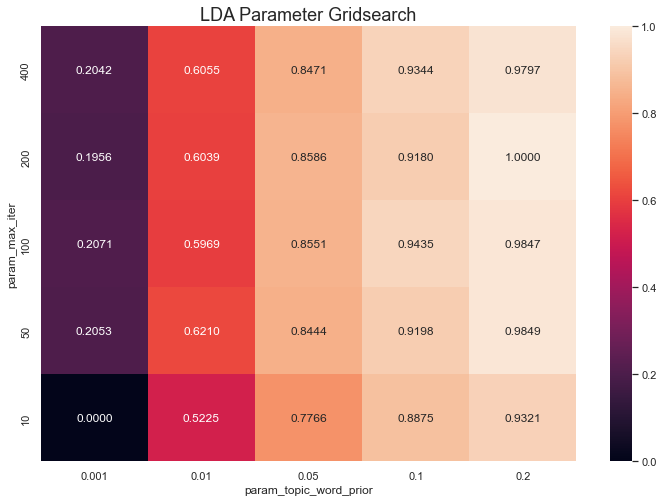

In [39]:
# Create a dataframe with the sorted results from gridsearch 
# Ref: https://scikit-learn.org/stable/modules/grid_search.html
cv_results = pd.DataFrame(model.cv_results_).sort_values("mean_test_score", ascending=False)

# Select hyperparameter columns and mean_test_score
cv_results = cv_results[['param_max_iter', 'param_topic_word_prior', 'mean_test_score']]

# In an effort to make the visualization more readable, I will be rescaling results from [0, 1]
scaler = MinMaxScaler()
cv_results['mean_test_score'] = scaler.fit_transform(cv_results['mean_test_score'].values.reshape(-1,1))

# Create a pivot table to represent mean_test_score values over hyperparameter columns and indices
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_max_iter"],
    columns=["param_topic_word_prior"])

# Plot the gridsearch heatmap
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
sns.heatmap(pivoted_cv_results, annot=True, cmap="rocket", fmt='.4f', ax=ax, vmin=0, vmax=1)
ax.set_title("LDA Parameter Gridsearch", fontsize=18); ax.invert_yaxis();

In [40]:
# Fit the final LDA model 
lda, y_tr_lda, vec_lda, lda_labels, lda_acc = fit_Dirichlet(train_, miter=200, twp=0.2)

---

## Results and Analysis:


__Training accuracy__

* Since this dataset has internal validity indices (i.e. we know the article categories in the training set) I will evaluate model performance by reporting training accuracy, precision, recall, and F1-score. Confusion matrices will visualize topic predictions compared to the true topic labels. 

In [41]:
# Display hieararchical clustering training accuracy
display(Markdown(f"<b>K-means clustering</b><br>\n* Training accuracy = {km_acc}"))

# Display hieararchical clustering training accuracy
display(Markdown(f"<br><b>Hierarchical clustering</b><br>\n* Training accuracy = {agg_acc}"))

# Display LDA training accuracy and top topics terms (i.e. terms with highest topic probaiblity)
display(Markdown(f"<br><b>Latent Dirichlet Allocation</b><br>\n* Training accuracy = {lda_acc}"))

<b>K-means clustering</b><br>
* Training accuracy = 0.9395

<br><b>Hierarchical clustering</b><br>
* Training accuracy = 0.9326

<br><b>Latent Dirichlet Allocation</b><br>
* Training accuracy = 0.9333

__Confusion matrices__

* Next, I will plot confusion matrices for each model. These are generated by comparing the article topics predicted from the training set with the true article topic labels. Recall, we have the true article topic labels because the training set has topic labels in the `Category` feature.

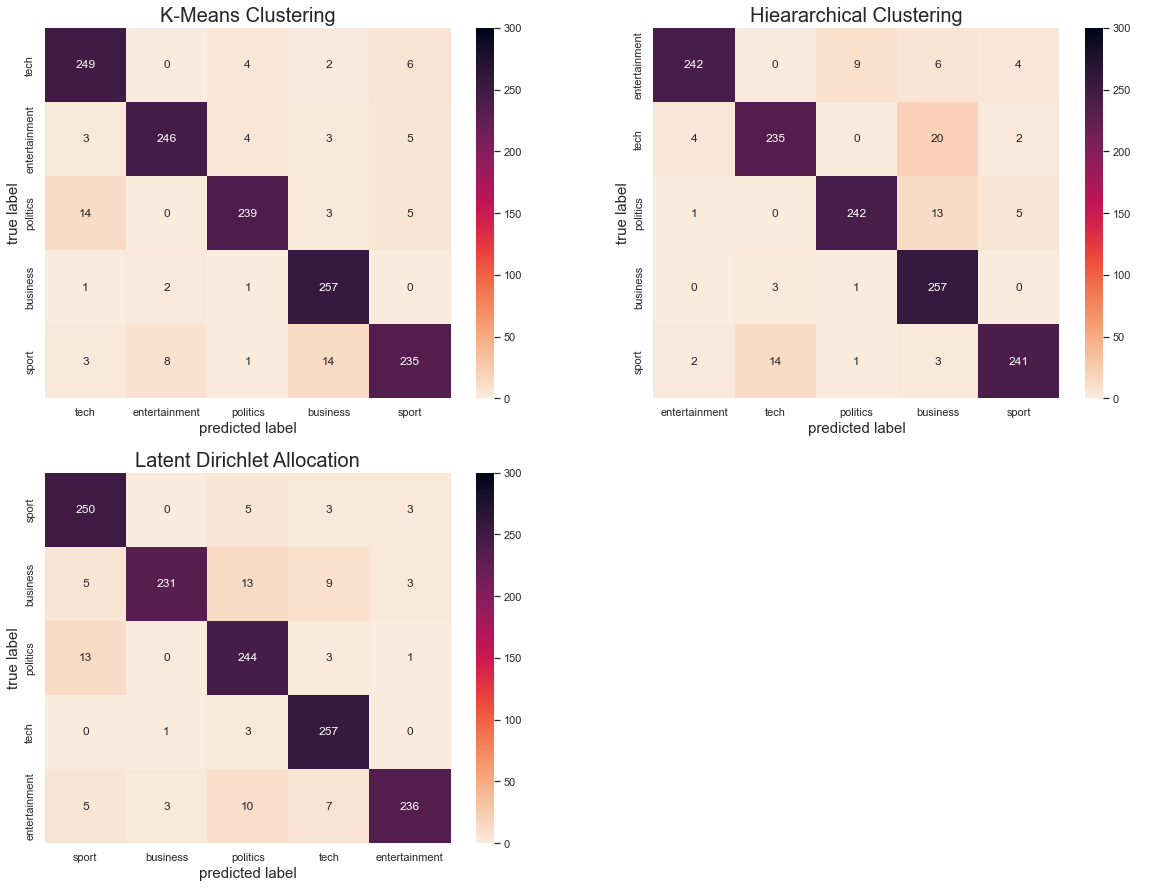

In [42]:
# Collect predictions and labels from all models
ids = ["K-Means Clustering", "Hieararchical Clustering", "Latent Dirichlet Allocation"]
total_yp = [x_train_km, agg.labels_, y_tr_lda]
total_yt = [train_.Category] * 3
total_labels = [km_labels, agg_labels, lda_labels]

# Plot confusion matrices for each model
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
for yp, yt, labels, title, ax in zip(total_yp, total_yt, total_labels, ids, axes.flat):
    # Create a confusion matrix using the best linkage method and distance metric
    labeled_yp = assign_cluster_labels(yp, labels)
    cm = confusion_matrix(yt, labeled_yp)

    # Plot the heatmap
    cm_heatmap = sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels, 
                            cmap='rocket_r', ax=ax, vmin=0, vmax=300)

    # Heatmap settings
    ax.set_title(label=f"{title}", fontdict={'fontsize':20})
    ax.set_ylabel("true label", fontsize=15); ax.set_xlabel("predicted label", fontsize=15);
axes[1,1].set_axis_off()

__Classification metrics__

* Lastly, I will evaluate model performance by computing precision, recall, and F1-score classification metrics for each model's predictions.

In [43]:
# Print classification reports for predictions made by each model
for yp, yt, labels, title in zip(total_yp, total_yt, total_labels, ids):
    labeled_yp = assign_cluster_labels(yp, labels)
    display(Markdown(f"### {title} classification report"))
    print(classification_report(y_true=yt, y_pred=labeled_yp))

### K-Means Clustering classification report

               precision    recall  f1-score   support

     business       0.92      0.95      0.94       261
entertainment       0.96      0.94      0.95       261
     politics       0.96      0.92      0.94       261
        sport       0.92      0.98      0.95       261
         tech       0.94      0.90      0.92       261

     accuracy                           0.94      1305
    macro avg       0.94      0.94      0.94      1305
 weighted avg       0.94      0.94      0.94      1305



### Hieararchical Clustering classification report

               precision    recall  f1-score   support

     business       0.97      0.93      0.95       261
entertainment       0.93      0.90      0.92       261
     politics       0.96      0.93      0.94       261
        sport       0.86      0.98      0.92       261
         tech       0.96      0.92      0.94       261

     accuracy                           0.93      1305
    macro avg       0.94      0.93      0.93      1305
 weighted avg       0.94      0.93      0.93      1305



### Latent Dirichlet Allocation classification report

               precision    recall  f1-score   support

     business       0.92      0.96      0.94       261
entertainment       0.98      0.89      0.93       261
     politics       0.89      0.93      0.91       261
        sport       0.92      0.98      0.95       261
         tech       0.97      0.90      0.94       261

     accuracy                           0.93      1305
    macro avg       0.94      0.93      0.93      1305
 weighted avg       0.94      0.93      0.93      1305



__Results summary and analysis__

* All three models adequately predicted article topics from the training set. Each has relatively high training accuracy at approximately 0.93.

* K-means very slightly outperformed hierarchical clustering and LDA, having higher training accuracy and weighted F1 scores. 

* Confusion matrices and classification metrics provide some interesting insights into each model's weaknesses at separating different topics from the articles:

    * K-means clustering had difficulty separating `politics` from `tech` articles, and `sports` from `business` articles.

    * Hierarchical clustering had difficulty separating `sports` from `tech` articles, and `tech` from `business` articles.

    * LDA had difficulty separating `politics` from `sport` articles and `business` from `politics` articles.

* This difference between the clustering algorithms and LDA is interesting, and may indicate that certain topics are more readily clustered than others. For example, the technology cluster may be difficult to separate as it is often involved in other topics. 

* However, while we compare the performance of these models it is important to remember that all of these algorithms are non-deterministic. This means we will get different results each time they are run, because every algorithm involves a degree of randomness during initialization. For example, the initial locations of K-means centroids is random, as are the initial article-topic probabilities during the first iteration of LDA. 

* Considering the non-deterministic nature of these algorithms, while we can compare accuracy and F1 scores from run to run, it can be difficult to compare different topic predictions each run.

## Conclusions and Discussion

__Summary of results__

* Overall, all models accurately (>0.90 accuracy) classified article topics. K-means and LDA performed slightly better than hierarchical clustering and this is supported by accuracy and weighted F1 scores.

* Both clustering models had more incorrect predictions concentrated within specific, possibly interrelated topics, such as `tech` and `business`. 

__Discussion and improvements__

One of the more difficult challenges in this project was data cleaning. Examining the text through EDA made it quickly apparent that the quality of cleaning can dramatically affect how the models are trained. For example, prior to removing stop words, much of the data in bigrams and word clouds had words that did not offer any context, such as "and the", or "told us". However, too much cleaning can make it more difficult to separate topics that often have related contexts, such as `sports` and `entertainment` or `business` and `politics`. In this sense, cleaning text data seems to be more of a skill than a process, and I think more care in data cleaning could create some improvements in the performance of each model.

Compared to the clustering algorithms, working with LDA was challenging. It's an algorithm we have not covered, which posed its own challenges. Additionally, there are a plethora of hyperparameters to choose from depending on the learning method chosen: [see sklearn LDA hyperparameters](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html). I opted to choose the `batch` learning method and tuned two hyperparameters with grid search. This learning method uses the entire training data when updating topic probabilities during each iteration, and this seemed fine since our dataset is small. Given more time, I would like to learn more about this algorithm and see if there are ways to tune further in order to achieve better performance.